In [1]:
import numpy as np
import pandas as pd 
import os
import math
import random
import pydicom
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from PIL import Image
import pickle
from sklearn.metrics import classification_report, confusion_matrix 
from concurrent.futures import ProcessPoolExecutor
#from tensorflow.keras.metrics import F1Score


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
input_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
data = os.listdir(input_path + "stage_2_train")
print(len(data))
print(data[:10])

752803
['ID_27a354d42.dcm', 'ID_9ef779a18.dcm', 'ID_5bed38bf6.dcm', 'ID_286599272.dcm', 'ID_bba76cea8.dcm', 'ID_a917377cd.dcm', 'ID_7723b03a6.dcm', 'ID_dbb1cc814.dcm', 'ID_4b08fe185.dcm', 'ID_8192d735e.dcm']


In [3]:
df = pd.read_csv(input_path+"stage_2_train.csv") # read csv file with labels
df = df.drop_duplicates() # remove duplicated data
labels =  df.Label.values # get labels column

df = df.ID.str.rsplit("_",n=1,expand=True) # separate image ID and subtype into 2 columns 
df.loc[:, "label"] = labels 
df.head()

df = df.rename({0 : "Image",1 : "Subtype"}, axis=1) # define colum headings

print("Dataframe shape : ",df.shape)
print("\nDataframe :\n")
print(df[:10])

Dataframe shape :  (4516818, 3)

Dataframe :

          Image           Subtype  label
0  ID_12cadc6af          epidural      0
1  ID_12cadc6af  intraparenchymal      0
2  ID_12cadc6af  intraventricular      0
3  ID_12cadc6af      subarachnoid      0
4  ID_12cadc6af          subdural      0
5  ID_12cadc6af               any      0
6  ID_38fd7baa0          epidural      0
7  ID_38fd7baa0  intraparenchymal      0
8  ID_38fd7baa0  intraventricular      0
9  ID_38fd7baa0      subarachnoid      0


In [4]:
def dafa_frame2dic (dataframe):
    # Create a pivot table with image IDs as rows and subtypes as columns
    pivot_table = dataframe.pivot(index='Image', columns='Subtype', values='label')
    
    # Fill missing values with 0 (for subtypes that are not present for a specific image)
    pivot_table = pivot_table.fillna(0)
    
    pivot_table = pivot_table.drop(columns="any") # drop the column named "any"
    
    print (pivot_table)
    
    # Convert the pivot table to a dictionary with image IDs as keys and row vectors of labels as values
    label_dict = pivot_table.apply(lambda row: row.values.tolist(), axis=1).to_dict()

    return label_dict

original_dict = dafa_frame2dic (df)

Subtype       epidural  intraparenchymal  intraventricular  subarachnoid  \
Image                                                                      
ID_000012eaf         0                 0                 0             0   
ID_000039fa0         0                 0                 0             0   
ID_00005679d         0                 0                 0             0   
ID_00008ce3c         0                 0                 0             0   
ID_0000950d7         0                 0                 0             0   
...                ...               ...               ...           ...   
ID_ffff82e46         0                 0                 0             0   
ID_ffff922b9         0                 0                 1             0   
ID_ffffb670a         0                 0                 0             1   
ID_ffffcbff8         0                 0                 0             0   
ID_fffff9393         0                 0                 0             0   

Subtype    

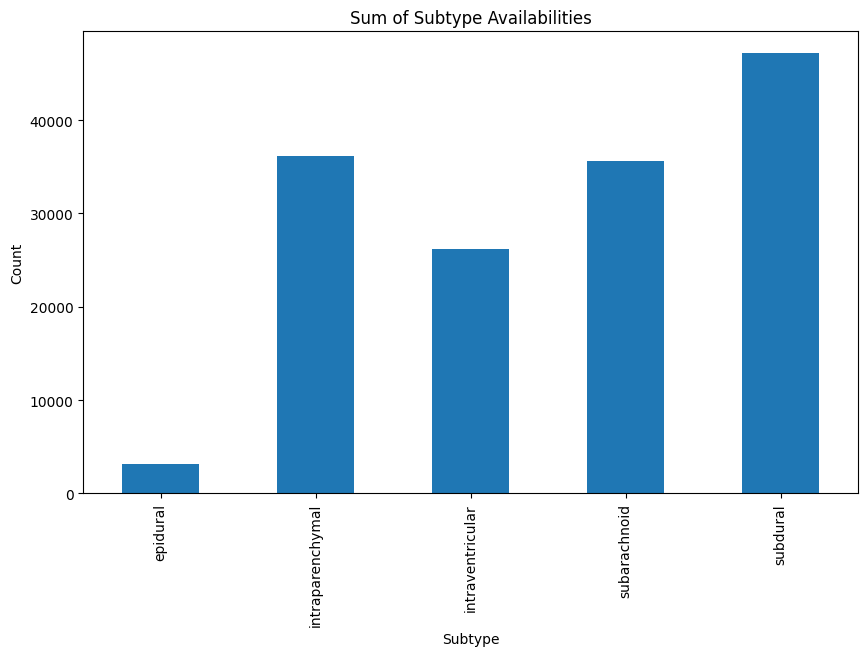

In [5]:
# Plot data distribution

data_df = pd.DataFrame(original_dict).T  # Convert the dictionary into a DataFrame & transpose to have the correct orientation

# Rename the columns to represent the subtypes
data_df.columns = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

# Calculate the sum of each subtype column
subtype_sum = data_df.sum()

# Plot the results in a bar graph
plt.figure(figsize=(10, 6))
subtype_sum.plot(kind='bar')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.title('Sum of Subtype Availabilities')
plt.show()


In [6]:
# Separating dataset into hemorrhage and non hemmrrhage

hemorrhage_dict = {}
non_hemorrhage_dict = {}

for image_id, label in original_dict.items():
    if any(label):
        hemorrhage_dict[image_id] = label
    else:
        non_hemorrhage_dict[image_id] = label
        

In [7]:
print("Hemorrhage positive data: ",len(hemorrhage_dict))
print("Hemorrhage negative data: ",len(non_hemorrhage_dict))

Hemorrhage positive data:  107933
Hemorrhage negative data:  644870


In [8]:
non_hemorrhage_keys = list(non_hemorrhage_dict.keys())
selected_non_hemorrhage_keys = random.sample(non_hemorrhage_keys, 150000) # Randomly select 150,000 non_hemorrhage data

new_non_hemorrhage_dict = {k: non_hemorrhage_dict[k] for k in selected_non_hemorrhage_keys} # Create a new dictionary with the selected non-hemorrhage entities
combined_dict = {**hemorrhage_dict, **new_non_hemorrhage_dict} # Merge the new non-hemorrhage dictionary with the hemorrhage dictionary


shuffled_dict = dict(random.sample(combined_dict.items(), len(combined_dict))) # Shuffle the combined dictionary
print("Shuffled dictionary size: ",len(shuffled_dict))

/tmp/ipykernel_32/4282421822.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  shuffled_dict = dict(random.sample(combined_dict.items(), len(combined_dict))) # Shuffle the combined dictionary


Shuffled dictionary size:  257933


In [9]:
# Randomply split data into train set, test set and validation set

from sklearn.model_selection import train_test_split

key_list = list(shuffled_dict.keys())

train_keys, test_keys = train_test_split(key_list, test_size = 0.2, random_state = 42)
test_keys, val_keys = train_test_split(test_keys, test_size = 0.5, random_state = 42)

train_dict = {key: shuffled_dict[key] for key in train_keys}
test_dict = {key: shuffled_dict[key] for key in test_keys}
val_dict = {key: shuffled_dict[key] for key in val_keys}

In [10]:
print("train set size: ",len(train_dict))
print("test set size: ",len(test_dict))
print("validation set size: ",len(val_dict))

train set size:  206346
test set size:  25793
validation set size:  25794


In [ ]:
# get image data correspond to train, test and validation sets

from pathos.multiprocessing import ProcessingPool as Pool

def map_images_to_labels(label_dict, image_dir, num_processes=4):
    id_array = list(label_dict.keys())
    labels = np.array(list(label_dict.values()))
    
    # Define a function for parallel processing
    def process_image_path(ID):
        return os.path.join(image_dir, f'{ID}.dcm')
    
    # Use pathos multiprocessing to construct image paths in parallel
    with Pool(num_processes) as pool:
        image_paths = pool.map(process_image_path, id_array)
    
    return image_paths, labels

image_dir = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'

train_image_paths, _ = map_images_to_labels(train_dict, image_dir)
val_image_paths, _ = map_images_to_labels(val_dict, image_dir)
test_image_paths, _ = map_images_to_labels(test_dict, image_dir)

In [148]:
# Preprocessing images

# Windowing
def apply_window(dcm_image,window):
    
    #define center and width for each type of window
    if window == "brain":
        w_center = 40
        w_width = 80
    elif window == "subdural":
        w_center = 80
        w_width = 200
    elif window == "soft_tissue":
        w_center = 40
        w_width = 380
        
    windowed_img = dcm_image.pixel_array * dcm_image.RescaleSlope + dcm_image.RescaleIntercept #image reconstruction
    
    minimum = w_center - w_width//2 #window lower limit
    maximum = w_center + w_width//2 #window upper limit
    windowed_img = np.clip(windowed_img, minimum, maximum) #replace values <minimum with minimum and values > maximum with maximum
    
    normalized_Image = (windowed_img - minimum) / (w_width)
    #print(normalized_Image.shape)
    return normalized_Image


# Form color images
def build_colorImage(dcm_image ,image_size):
    
    brain = apply_window(dcm_image,"brain")
    subdural = apply_window(dcm_image,"subdural")
    soft_tissue = apply_window(dcm_image,"soft_tissue")
    
    resized_brain = cv.resize(brain, image_size, interpolation = cv.INTER_LINEAR)
    resized_subdural = cv.resize(subdural, image_size, interpolation = cv.INTER_LINEAR)
    resized_soft_tissue = cv.resize(soft_tissue, image_size, interpolation = cv.INTER_LINEAR)

    win_combinedImage = cv.merge((resized_brain, resized_subdural, resized_soft_tissue))
    
    return win_combinedImage

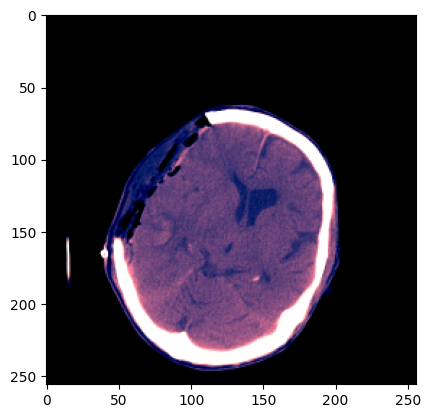

In [150]:
test_image_path = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"+ data[1]
test_image = pydicom.dcmread(test_image_path)
test_image_colored = build_colorImage(test_image ,(256,256))

plt.imshow(test_image_colored)


In [14]:
# Build the model


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Attention, GlobalAveragePooling2D
#from retnet import ReXNetV1
#from efficientnet.tfkeras import EfficientNetB0  # You may choose a different variant (e.g., B1, B2, etc.)

def set_model (model_type):
    
    if model_type == "CNN":
        
        # Define the CNN model
        model = keras.Sequential([
            Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(256, activation='relu'),
            Dense(5, activation = "sigmoid")  # 5 output neurons with sigmoid activation
        ])

        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy']) # Compile the model
        
        return model
        
    
    elif model_type == "ResNet50":
        input_tensor = Input(shape=(256, 256, 3))

        base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

        x = base_model.output
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Attention()([x, x])
        predictions = Dense(5, activation='sigmoid')(x)  # 5 output neurons with sigmoid activation
        
        model = keras.Model(inputs=input_tensor, outputs=predictions) 
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])# Compile the model
 
        return model 

   
    elif model_type == "Custom":

        # Define a custom model with attention mechanism
        input_tensor = Input(shape=(256, 256, 3))

        x = Conv2D(64, (3, 3), activation='relu')(input_tensor)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Attention()([x, x])  # Adding attention mechanism
        predictions = Dense(5, activation='sigmoid')(x)  # 5 output neurons with sigmoid activation

        model = keras.Model(inputs = input_tensor, outputs = predictions)
       
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])  # Compile the model
        return model

In [15]:
# Train and validation data generator

class train_val_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, label_dict, batch_size, image_size, shuffle=True):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        X, labels = self.__data_generation(batch_image_paths)
        
        return X,labels 
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_image_paths):
        X = []
        labels = []
        global Type
        for image_path in batch_image_paths:
            try:
                dcm_image = pydicom.dcmread(image_path)       
                color_image = build_colorImage(dcm_image ,self.image_size)

                X.append(color_image) #new
                labels.append(self.label_dict[image_path[-16:-4]])
            
            except Exception as e:
                print("Error file found: ",image_path)
                continue

        X = np.array(X)
        labels=np.array(labels)
        
        
        return X, labels

In [129]:
# Test data genertion
class test_DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels=None, batch_size=128, image_size=(256, 256), shuffle = False):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        
        X_test, y_test = self.__data_generation(batch_image_paths)

        return X_test, y_test    

  
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)      
    
    
    def __data_generation(self, batch_image_paths):
        X_test = [] # store images
        y_test = [] # store labels
        #image_ids = []  # store image IDs

        for image_path in batch_image_paths:
            try:
                dcm_image = pydicom.dcmread(image_path)
                color_image = build_colorImage(dcm_image, self.image_size)

                X_test.append(color_image)
                
                if self.labels is not None:
                    # Get the corresponding labels
                    y_test.append(self.labels[image_path[-16:-4]])
                else:
                    pass
                # Store the image ID
                #image_ids.append(os.path.basename(image_path).split('.')[0])

            except Exception as e:
                print("Error file found: ", e)
                continue

        X_test = np.array(X_test)
        y_test = np.array(y_test)

        return X_test, y_test #, image_ids
    
    def predict_data(self, model):
       
        predictions = model.predict(self)  # Generate predictions for the data
        predictions = (predictions >= 0.5).astype(int) # get predictions in binary format
        
        return predictions

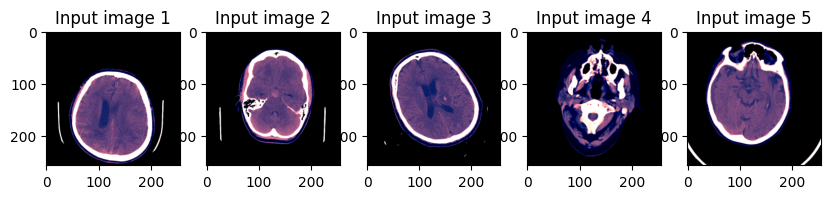

In [17]:
epochs = 2
batch_size = 128
image_size = (256, 256)
     
# Create the data generator
train_generator = train_val_DataGenerator (train_image_paths, label_dict = train_dict, batch_size = batch_size, image_size = image_size, shuffle = True)
val_generator = train_val_DataGenerator (val_image_paths, label_dict = val_dict, batch_size = batch_size, image_size = image_size, shuffle = True)

first_train_batch = train_generator[0]
images_batch , label_batch = first_train_batch

first_five_images = images_batch[:5]

fig, axes = plt.subplots(1,5, figsize =(10,10))

for index, ax in enumerate(axes):
    ax.imshow(first_five_images[index])
    ax.set_title("Input image " + str(index+1))
    #ax.axis("off")
plt.show()

In [18]:
model = set_model("Custom")
model.fit(train_generator, epochs=epochs, verbose=1, validation_data = val_generator)

Epoch 1/2
1613/1613 [==============================] - 5632s 3s/step - loss: 0.5177 - binary_accuracy: 0.8709 - val_loss: 0.3489 - val_binary_accuracy: 0.8850
Epoch 2/2
1613/1613 [==============================] - 5179s 3s/step - loss: 0.3967 - binary_accuracy: 0.8809 - val_loss: 0.3376 - val_binary_accuracy: 0.8849


In [41]:
test_generator = test_DataGenerator (test_image_paths, labels = test_dict, batch_size = 128, image_size = (256,256),shuffle = False)


test_batch = test_generator[0]  # Fetch the first batch of data from the generator
X_test_batch, y_test_batch = test_batch  # Unpack the data batch
print("Shape of X_test in the first batch:", X_test_batch.shape)
print("Shape of y_test in the first batch:", y_test_batch.shape)


loss, accuracy = model.evaluate(test_generator)

print('Test accuracy:', accuracy)


Shape of X_test in the first batch: (128, 256, 256, 3)
Shape of y_test in the first batch: (128, 5)
202/202 [==============================] - 257s 1s/step - loss: 0.3392 - binary_accuracy: 0.8825
Test accuracy: 0.8825030326843262


In [84]:
def get_dicom_paths_in_directory(directory_path):
    return [entry.path for entry in os.scandir(directory_path) if entry.name.endswith('.dcm')]

# Path to directory containing images
test_directory_path = "" 
image_paths_list = get_dicom_paths_in_directory(test_directory_path)

In [ ]:
def predict_data(image_paths_list, model):
    model = model
    data_generator = test_DataGenerator (image_paths_list[:256], labels = None, batch_size = 128, image_size = (256,256),shuffle = False)
    predictions = data_generator.predict_data(model)
    return predictions

In [ ]:
#make predictions

run = predict_data(image_paths_list, model)    